In [40]:
using JuMP, Clp, Plots, CSV, DataFrames

In [58]:
itsa4 = CSV.read("itsa4.csv", DataFrame)
itsa4p = parse.(Float64,replace.(itsa4[!,:VARIAÇÃO],","=>"."))

mglu3 = CSV.read("mglu3.csv", DataFrame)
mglu3p = parse.(Float64,replace.(mglu3[!,:VARIAÇÃO],","=>"."))

vale3 = CSV.read("vale3.csv", DataFrame)
vale3p = parse.(Float64,replace.(vale3[!,:VARIAÇÃO],","=>"."))

amer3 = CSV.read("amer3.csv", DataFrame)
amer3p = parse.(Float64,replace.(amer3[!,:VARIAÇÃO],","=>"."))

lwsa3 = CSV.read("lwsa3.csv", DataFrame)
lwsa3p = parse.(Float64,replace.(lwsa3[!,:VARIAÇÃO],","=>"."));

abev3 = CSV.read("abev3.csv", DataFrame)
abev3p = parse.(Float64,replace.(abev3[!,:VARIAÇÃO],","=>"."));

sapr4 = CSV.read("sapr4.csv", DataFrame)
sapr4p = parse.(Float64,replace.(sapr4[!,:VARIAÇÃO],","=>"."));

taee4 = CSV.read("taee4.csv", DataFrame)
taee4p = parse.(Float64,replace.(taee4[!,:VARIAÇÃO],","=>"."));

ggbr4 = CSV.read("ggbr4.csv", DataFrame)
ggbr4p = parse.(Float64,replace.(ggbr4[!,:VARIAÇÃO],","=>"."));

nrow(sapr4)

50

In [61]:
num_assets = 9
num_scenarios = 50
r = permutedims(hcat(reshape(itsa4p, 50),
                    reshape(mglu3p, 50),
                    reshape(vale3p, 50),
                    reshape(amer3p, 50),
                    reshape(lwsa3p, 50),
                    reshape(abev3p, 50),
                    reshape(sapr4p, 50),
                    reshape(taee4p, 50),
                    reshape(ggbr4p, 50)))
p = 1/num_scenarios
α = 0.9

0.9

=========== ω = 0.0 ===========
optimal solution = -0.0682
x = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
l = 2.6
θ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Expected Value: -0.0682
CVAR: 2.6
=========== ω = 0.1 ===========
optimal solution = 0.15722000000000003
x = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
l = 1.7599999999999996
θ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030000000000000134, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0800000000000007, 0.0, 0.5500000000000003, 0.0, 0.0, 0.0, 0.0, 0.8400000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6300000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Expected Value: -0.0682
CVAR: 2.186
=========== ω = 0.2 ===========
optimal solution = 0.37223003535774024
x = [0.1027

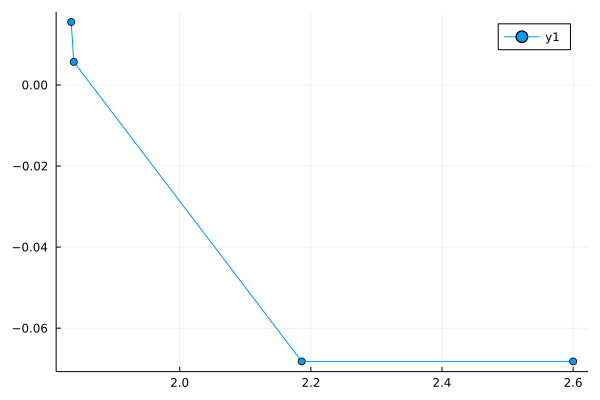

In [65]:
cvar_list = []
expected_value_dict = Dict{Float64, Float64}();
for ω in 0.0:0.1:1.0
    
    model_Portifolio = Model(Clp.Optimizer)
    set_optimizer_attribute(model_Portifolio, "LogLevel",0)

    @variables(model_Portifolio,
    begin
        x[1:num_assets] ≥ 0
        l ≥ 0
        θ[1:num_scenarios] ≥ 0
    end)

    @constraints(model_Portifolio,
    begin
        ct1, sum(x[i] for i = 1:num_assets) == 1
        ct2[s=1:num_scenarios], θ[s] ≥ sum(-r[i,s]*x[i] for i = 1:num_assets) - l
    end)

    @objective(model_Portifolio, Min, (1-ω)*sum(p*(sum(-r[i,s]*x[i] for i = 1:num_assets)) for s = 1:num_scenarios) + ω * (l + sum(p*θ[s]/(1-α) for s = 1:num_scenarios)))
    optimize!(model_Portifolio);
    
    cvar = value(l) + sum(p*value(θ[s])/(1-α) for s = 1:num_scenarios)
    exp_value = sum(p*(sum(-r[i,s]*value(x[i]) for i = 1:num_assets)) for s = 1:num_scenarios)
    
    append!(cvar_list,cvar)
    push!(expected_value_dict,cvar => exp_value)
    
    println("=========== ω = $(ω) ===========")
    println("optimal solution = $(objective_value(model_Portifolio))")
    println("x = $(value.(x))")
    println("l = $(value(l))")
    println("θ = $(value.(θ))")
    println("Expected Value: $(exp_value)")
    println("CVAR: $(cvar)")
end
plot(x=cvar_list,expected_value_dict, shape = :circle)

In [66]:
cvar_list = []
expected_value_list = []
for γ in 0.0:0.1:1.0
    
    model_Portifolio = Model(Clp.Optimizer)
    set_optimizer_attribute(model_Portifolio, "LogLevel",0)

    @variables(model_Portifolio,
    begin
        x[1:num_assets] ≥ 0
        l ≥ 0
        θ[1:num_scenarios] ≥ 0
    end)

    @constraints(model_Portifolio,
    begin
        ct1, sum(x[i] for i = 1:num_assets) == 1
        ct2[s=1:num_scenarios], θ[s] ≥ sum(-r[i,s]*x[i] for i = 1:num_assets) - l
        ct3, l + sum(p*θ[s] for s = 1:num_scenarios)/(1-α) ≤ γ
    end)

    @objective(model_Portifolio, Min, sum(p*(sum(-r[i,s]*x[i] for i = 1:num_assets)) for s = 1:num_scenarios))
    optimize!(model_Portifolio);
    
    cvar = value(l) + sum(p*value(θ[s])/(1-α) for s = 1:num_scenarios)
    exp_value = sum(p*(sum(-r[i,s]*value(x[i]) for i = 1:num_assets)) for s = 1:num_scenarios)
    
    append!(cvar_list,cvar)
    append!(expected_value_list,exp_value)
    
    println("=========== γ = $(γ) ===========")
    println("optimal solution = $(objective_value(model_Portifolio))")
    println("x = $(value.(x))")
    println("l = $(value(l))")
    println("θ = $(value.(θ))")
    println("Expected Value: $(exp_value)")
    println("CVAR: $(cvar)")
end

plot(x=cvar_list,expected_value_list, shape = :circle)

LoadError: Primal solution not available